In [1]:
import re
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tqdm import tqdm
import spacy
import ast      
import seaborn as sns
from matplotlib import pyplot as plt
import colorcet as cc

In [2]:
# To generate data/adjectives_nouns. Takes 20-30 minutes to run

# stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
#     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
#     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 
#     'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
#     'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
#     'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
#     'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
#     'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
#     'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
#     't', 'can', 'will', 'just', 'don', 'should', 'now']

# def pre_process(sentence):
#     """
#     stopwords removal, punctuations removal, stemming/lemmentizing
#     """
    
#     #remove punctuations
#     pattern = re.compile(r'[^\w\s]')
#     sent_cleaned = pattern.sub('',str(sentence).lower())
    
#     #remove stopping words, such as of, is, and, I, am, ...
#     phrases_cleaned = ' '.join([i for i in sentence.split() if i not in stopwords])

#     #stemming (no need lemmentization)
#     lemmatizer = WordNetLemmatizer()
#     phrases_cleaned = [' '.join([lemmatizer.lemmatize(i) for i in s.split()]) for s in phrases_cleaned]
    
#     return sentence

# # Load English tokenizer, tagger, parser and NER
# nlp = spacy.load("en_core_web_sm")
# #spacy.prefer_gpu()

# tqdm.pandas()

# def get_adjectives(text, tag_ = 'JJ'):
#     blob = nlp(text)
#     return [ token.lemma_ for token in blob if token.tag_ == tag_]


# df = pd.read_csv('./data/winemag-data-130k-v2_cleaned.csv')
# df['description_cleaned'] = df['description'].progress_apply(lambda x: pre_process(x))
# df['description_adj_cleaned'] = df['description'].progress_apply(get_adjectives)
# df['description_noun_cleaned'] = df['description'].progress_apply(lambda x: get_adjectives(x, tag_ = 'NN'))
# df.to_csv('./data/adjectives_nouns.csv')

In [3]:
tqdm.pandas()

df = pd.read_csv('./data/adjectives_nouns.csv')
df['description_adj_cleaned'] = df['description_adj_cleaned'].apply(lambda x: ast.literal_eval(x))
df['description_noun_cleaned'] = df['description_noun_cleaned'].apply(lambda x: ast.literal_eval(x))

In [4]:
from collections import defaultdict

def counts(df_col):
    cc = defaultdict(int)
    
    def fun(x):
        for i in x:
            cc[i] += 1
        return True
    df_col.progress_apply(lambda x: fun(x) )
    
    return sorted(cc.items(), key=lambda x:x[1], reverse=True)

def percent_range(col_name, df_=df, N = 5):
    percent = [(i+1) * (1.0/N) for i in range(N-1)]
    x_percentile = df_[col_name].describe(percentiles=percent)
    
    if N %2 == 1:
        x_percentile = x_percentile.drop(index=['50%'])
    
    ranges = x_percentile[3:].values
    return ranges

def counts_table(df, col_name, common_filter=0):
    df['points_range'] = pd.cut(df["points"], percent_range("points"))
    
    common_words = set([i[0] for i in counts(df[col_name])[:common_filter] ])
    
    return df.groupby('points_range')[col_name].apply(lambda x: counts(x)).apply(lambda x: [i for i in x if i[0] not in common_words])

In [5]:
adjs = counts_table(df, 'description_adj_cleaned',common_filter=20)

100%|████████████████████████████████████████████████████████████████████████| 22276/22276 [00:00<00:00, 860009.72it/s]


In [6]:
def draw_fig(ct, title_ = 'Top Flavors', save=True, topk=5, max_=1):
    uniques = set()
    def fun(x):
        for i in x:
            uniques.add(i[0])
        return True
    ct.apply(lambda x: fun(x))
    
    custom_palette = {i:j for i,j in zip(uniques, sns.color_palette(cc.glasbey, n_colors=len(uniques))) }
    #print(custom_palette)
    
    fig, axs = plt.subplots(1,len(ct),figsize = (3*len(ct),5))
    first = True
    for ax, g_id in zip(axs,ct.index):
        df_tmp = pd.DataFrame(ct[g_id], columns = ['name','value'])[:topk]
        df_tmp['value'] = df_tmp['value']/(len(df)//len(ct))
        plot_ = sns.barplot(data=df_tmp, y='name', x='value', ax=ax, orient='h', palette=custom_palette)
        plot_.set(title=str(g_id))
        plot_.set(xlabel=None)
        plot_.set(ylabel=None)
        plot_.set(xlim=(0, max_))
        if first:
            first = False

        else:
            #plot_.set(yticklabels=[])
            first = first

    fig.suptitle(title_, fontsize=14)
    #fig.text(0.5, 0.0, 'common X', ha='center')
    fig.text(0.5, 0.0, 'Frequency', ha='center')
    plt.tight_layout()
    
    if save:
        plt.savefig(f'./{title_}.jpg',dpi=300)
    
    plt.show()
    
def draw_fig_new(ct, title_ = 'Top Flavors', save=True, topk=5, max_=1):
    for i in range(len(ct)):
        df_tmp = pd.DataFrame(ct.iloc[i], columns = ['name','value'])[:topk]
        df_tmp['value'] = df_tmp['value']/(len(df)//len(ct))
        sns.barplot(data=df_tmp, y = 'name', x='value', orient='h')
        

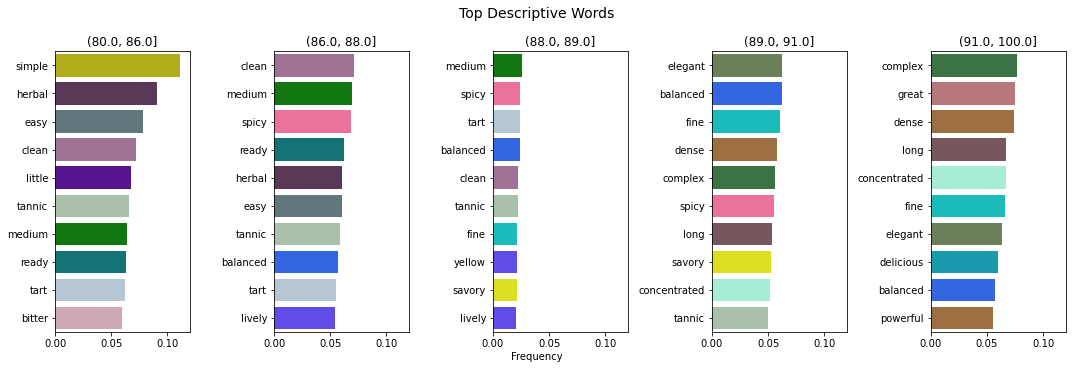

In [8]:
draw_fig(adjs, title_ = 'Top Descriptive Words', save=True, topk=10, max_ = 0.12)